<a href="https://colab.research.google.com/github/cow-coding/School-Project/blob/master/Computer%20Science/Artificial%20Intelligence/MNIST/CNN/CNN_MNIST_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init
from torch import optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
  torch.cuda.manual_seed_all(777)

# valriable setting

In [4]:
batch_size_train = 64
batch_size_val = 64
batch_size_test = 1000

learning_rate = 0.01

# Data load

In [5]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

print('training data number : %d' %len(mnist_train))
print('test data number : %d' %len(mnist_test))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Processing...
Done!
training data number : 60000
test data number : 10000


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
train_data, val_data = torch.utils.data.random_split(mnist_train, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size_test, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size_val, shuffle=True)

## Data Check

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


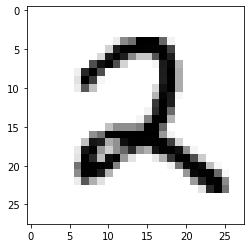

In [9]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Modeling

In [10]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)
    self.fc2 = nn.Linear(625, 10)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.leaky_relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = F.leaky_relu(self.conv3(x))
    x = F.max_pool2d(x, kernel_size=2, stride=2, padding=1)

    x = x.view(x.shape[0], -1)
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)

    return x

## Select Loss function

In [11]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)

## Optimizer Setting

In [12]:
optimizer = optim.SGD(cnn.parameters(), lr=learning_rate)

## Training

In [14]:
epochs = 5

for epoch in range(epochs):
  
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = cnn(images)
    loss = criterion(output, labels)

    loss.backward()
    optimizer.step()
  
  if epoch % 1 == 0:
    print("epoch {}, loss {}".format(epoch, loss.item()))

epoch 0, loss 1.5201876163482666
epoch 1, loss 0.21167917549610138
epoch 2, loss 0.07329957187175751
epoch 3, loss 0.09978577494621277
epoch 4, loss 0.010049802251160145


# Classification

In [15]:
corrects = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = cnn(images)
        
        preds = output.argmax(dim=1, keepdim=True)
        corrects += preds.eq(labels.view_as(preds)).sum().item()

acc = corrects / 10000 * 100
print("Accuracy : {:.2f}%".format(acc))

Accuracy : 96.39%
